# 13a: Discovering equation from experimental data using SINDy

**Solution:** [![Open in Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/kks32-courses/sciml/blob/main/lectures/13-sindy/13a-sindy-experiment.ipynb)

In this project, we want to discover a system of ordinary differential equations that describes the trajectory of the paint can in this video:

In [8]:
!pip3 install pysindy --quiet

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 121.0/121.0 kB 3.5 MB/s eta 0:00:00


In [12]:
!wget https://github.com/kks32-courses/sciml/raw/main/lectures/13-sindy/damped_oscillator_900.mp4

--2023-11-27 01:25:33--  https://github.com/kks32-courses/sciml/raw/main/lectures/13-sindy/damped_oscillator_900.mp4
Resolving github.com (github.com)... 192.30.255.112
Connecting to github.com (github.com)|192.30.255.112|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/kks32-courses/sciml/main/lectures/13-sindy/damped_oscillator_900.mp4 [following]
--2023-11-27 01:25:33--  https://raw.githubusercontent.com/kks32-courses/sciml/main/lectures/13-sindy/damped_oscillator_900.mp4
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 19025164 (18M) [application/octet-stream]
Saving to: ‘damped_oscillator_900.mp4.1’

damped_oscillator_9 100%[===================>]  18.14M  --.-KB/s    in 0.1s    

2023-11-27 

Our first task is to collect data points for our experiment — in this case our data points represent the position of the paint can over time. We could have taken many different approaches in the representation of this data. In this project our data $U$ consists of the (x, y) coordinates of the center of the paint can over the 425 frames in the video, so the shape of $U$ is 425 × 2. We gathered this information by using the CSRT Tracker found in the OpenCV package:

In [13]:
from IPython.display import HTML

# Replace the URL below with your raw GitHub video URL
video_url = "https://github.com/kks32-courses/sciml/raw/main/lectures/13-sindy/damped_oscillator_900.mp4"

HTML(f"""
<video width="640" height="480" controls>
  <source src="{video_url}" type="video/mp4">
</video>
""")


In [1]:
"""Utilities related to video."""

import logging
from typing import Tuple

import cv2
import numpy as np
from tqdm import tqdm


def track_object(input_file_path: str, bbox: Tuple[int],
                 output_file_path: str) -> np.ndarray:
    """
    Tracks an object in a video defined by the bounding box passed
    as a parameter. Saves an output video showing the bounding box found.
    Returns an ndarray of shape (frames, 2) containing the
    (x, y) center of the bounding box in each frame.
    """
    logging.info("Tracking object.")

    # Open video.
    capture = cv2.VideoCapture(input_file_path)
    if not capture.isOpened():
        raise Exception(f"Could not open video: {input_file_path}.")

    # Define tracker.
    tracker = cv2.TrackerCSRT_create()

    # Get the codec for an AVI file.
    fourcc = cv2.VideoWriter_fourcc(*"XVID")

    # Read each frame of the video, gather centers of all bounding boxes, and
    # save video showing those bounding boxes.
    color = (0, 0, 255)
    writer = None
    centers = []
    frame_count = int(capture.get(cv2.CAP_PROP_FRAME_COUNT))
    for i in tqdm(range(frame_count)):
        (ok, frame) = capture.read()
        if not ok:
            raise Exception(f"Cannot read video frame {i}.")

        if i == 0:
            # Uncomment this to select a bounding box interactively.
            # bbox = cv2.selectROI("Frame",
            #                      frame,
            #                      fromCenter=False,
            #                      showCrosshair=True)
            tracker.init(frame, bbox)
            writer = cv2.VideoWriter(output_file_path,
                                     fourcc,
                                     fps=30.0,
                                     frameSize=(frame.shape[1], frame.shape[0]))
        else:
            (ok, bbox) = tracker.update(frame)
            if not ok:
                raise Exception(f"Could not track object in frame {i}.")
        center = (bbox[0] + bbox[2] / 2, bbox[1] + bbox[3] / 2)
        centers.append(center)

        # Color the bounding box and center of an output video frame.
        x = int(center[0])
        y = int(center[1])
        fill_rectangle(frame, (x - 2, y, 2, 5, 5), color)
        outline_rectangle(frame, bbox, color)
        writer.write(frame)

    capture.release()
    writer.release()

    return np.asarray(centers)


def fill_rectangle(frame: np.ndarray, bbox: Tuple[int],
                   color: Tuple[int]) -> None:
    """Draws a filled rectangle with the specified bounding box and color
    on the frame.
    """
    for x in range(bbox[0], bbox[0] + bbox[2]):
        for y in range(bbox[1], bbox[1] + bbox[3]):
            set_color(frame, y, x, color)


def outline_rectangle(frame: np.ndarray, bbox: Tuple[int],
                      color: Tuple[int]) -> None:
    """Draws the outline of a rectangle with the specified bounding box and
    color on the frame.
    """
    for x in range(bbox[0], bbox[0] + bbox[2]):
        set_color(frame, bbox[1], x, color)
        set_color(frame, bbox[1] + bbox[3] - 1, x, color)

    for y in range(bbox[1], bbox[1] + bbox[3]):
        set_color(frame, y, bbox[0], color)
        set_color(frame, y, bbox[0] + bbox[2] - 1, color)


def set_color(frame: np.ndarray, x: int, y: int, color: Tuple[int]) -> None:
    """Sets the pixel at position (x, y) on the frame to the specified color.
    """
    frame[x, y, :] = np.asarray(color)



In the code above, the first parameter passed to the function is the path to the input video file, which we’ll open using OpenCV’s VideoCapture(...) function. We also receive the coordinates of the bounding box of the paint can in the first frame of the input video, in format (left, top, width, height). Then for each frame of the input video, we read it, get the bounding box for the paint can in that frame, calculate its center, and append the center to the centers list. In addition, we also receive as parameter a path to where we’ll save an output video file. This file contains the input video with the tracker findings overlayed on top of it: a red outline representing the bounding box around the paint can, and a red dot in its center. The (x, y) coordinates of the center dots over time make up our data matrix $U$, which we return in the end.

You may be wondering how you can figure out the bounding box of the paint can in the first frame. How did I come up with the coordinates (269, 433, 378, 464) in the code above? If you have access to Adobe Creative Cloud, you can open the video in Adobe Premiere Pro, export its first frame, open it in Adobe Photoshop, and get the coordinates for the top left corner, width and height. Otherwise, you can get the coordinates interactively through code. I left the code that provides this functionality in the project, commented out, in case you’d like to follow this approach in your project:


In [2]:
"""Utilities related to graphing."""

import matplotlib.pyplot as plt
import numpy as np


def style_axis2d(ax, xlabel: str, ylabel: str):
    """Styles a 2D graph.
    """
    very_light_gray = "#efefef"
    light_gray = "#999999"
    dark_gray = "#444444"

    ax.set_xlabel(xlabel, {"color": dark_gray})
    ax.set_ylabel(ylabel, {"color": dark_gray})
    ax.set_title(ax.get_title(), {"color": dark_gray})
    ax.tick_params(axis="x", colors=light_gray)
    ax.tick_params(axis="y", colors=light_gray)
    ax.set_facecolor(very_light_gray)
    for spine in ax.spines.values():
        spine.set_edgecolor(light_gray)


def graph_result(u: np.ndarray, u_approximation_x: np.ndarray,
                 u_approximation_y: np.ndarray, t: np.ndarray) -> None:
    """Graphs y(t).
    """
    orange = "#EF6C00"
    teal = "#007b96"

    fig = plt.figure(figsize=plt.figaspect(1))
    ax1 = fig.add_subplot(2, 1, 1)
    ax2 = fig.add_subplot(2, 1, 2, sharex=ax1, sharey=ax1)
    fig.tight_layout(pad=3)

    ax1.plot(t[:], u[:, 0], color=orange, linewidth=0.4)
    ax1.plot(t[:], u_approximation_x[:, 0], color=teal, linewidth=0.4)
    ax1.set_title("x(t)")
    style_axis2d(ax1, "t", "x")
    ax1.legend(labels=["Original trajectory", "SINDy approximation"],
               fontsize=8)

    ax2.plot(t[:], u[:, 1], color=orange, linewidth=0.4)
    ax2.plot(t[:], u_approximation_y[:, 0], color=teal, linewidth=0.4)
    ax2.set_title("y(t)")
    style_axis2d(ax2, "t", "y")
    ax2.legend(labels=["Original trajectory", "SINDy approximation"],
               fontsize=8)

    plt.show()

In [3]:
# Constants used in the Sequential Thresholded Least-Squares algorithm.
THRESHOLD = 0.001
MAX_ITERATIONS = 100

In [5]:
input_file_name = "damped_oscillator_900.mp4"
bbox = (269, 433, 378, 464)
output_file_name = "damped_oscillator_900_tracked.avi"
u = track_object(input_file_name, bbox, output_file_name)
t = np.arange(stop=u.shape[0])

100%|██████████| 425/425 [01:20<00:00,  5.26it/s]


And that’s all there is to it. We have our data $U$ and the corresponding timestamps $t$. We won’t calculate derivatives in this step — instead, we’ll have PySINDy calculate them in the fitting step. We’re now ready to use PySINDy to get a system of ordinary differential equations that describes the motion of the paint can.

## Fitting using PySINDy

If you try to ask PySINDy for a model by simply giving it all the data collected in the previous section, you won’t get great results. Machine learning is a powerful tool, but you still have to think and use good judgement. We may not know the exact equations of the movement, but we can use basic knowledge of ordinary differential equations to make some guesses that will help guide PySINDy in the right direction.

Let’s first consider the vertical movement of the paint can. This movement resembles that of the well-studied damped harmonic oscillator, which can be represented by the following second-order linear equation:

$$
\ddot{y} + \frac{b}{m}\dot{y} + \frac{k}{m}y = 0
$$

So, we can make an informed guess that our vertical coordinate $y$ will have strong similarities to this equation. However, the equation above is second-order, and PySINDy is only capable of discovering the function $f$ on the right-hand-side of first-order systems of the form:

$$\dot{u} = f(u)$$

Therefore, in order to make use of our assumption, we need to first turn the second-order damped harmonic oscillator equation into a system of two first-order equations. We can do that with the aid of two new variables, $y_1$ and $y_2$ , that correspond to the following:

$$
\begin{align*}
y_1 &= y \\
y_2 &= \dot{y}
\end{align*}
$$

The equation can then be re-written as the following system:


$$
\begin{align*}
\dot{y_1} &= y_2 \\
y_2 &= -\frac{b}{m}y_2 - \frac{k}{m}y_1
\end{align*}
$$

This is great information to have, because we now know that the vertical movement most likely needs two coordinates to be represented as a system of first-order equations: one of them being the $y$ coordinate that was recorded by the tracker, and the other one being its derivative. And we can pass along this information to PySINDy, as we’ll see later.

Now let’s consider the horizontal movement of the paint can. This time the movement resembles a pendulum, and we also have a well-studied ordinary differential equation that represents that trajectory. However, the movement is so slight that the damped harmonic oscillator equation is probably a good enough approximation for our purposes. It’s also much simpler than the pendulum equation, which would require a change of variables (great topic for a future post). Therefore, we’ll use the exact same technique to help PySINDy understand the horizontal movement: we’ll assume that it needs two coordinates, one of them being the $x$ coordinate recorded by the tracker, and the other one being its derivative.

You could try giving PySINDy data for these four coordinates, but I found that I get better results if I treat the horizontal and vertical movements as independent. As you can see in the code below, I create two independent PySINDy models, one for the horizontal movement, and another for the vertical movement:


In [9]:
from typing import Tuple

import pysindy as ps
# pylint: disable=unused-import
from pysindy.differentiation import FiniteDifference, SINDyDerivative
from pysindy.optimizers import STLSQ


def fit(u: np.ndarray,
        t: np.ndarray) -> Tuple[ps.SINDy, ps.SINDy, np.ndarray, np.ndarray]:
    """Uses PySINDy to find the equation that best fits the data u.
    """
    optimizer = STLSQ(threshold=THRESHOLD, max_iter=MAX_ITERATIONS)

    differentiation_method = FiniteDifference()
    # pylint: disable=protected-access
    udot = differentiation_method._differentiate(u, t)

    # Get a model for the movement in x.
    logging.info("Model for x")
    x = u[:, 0:1]
    xdot = udot[:, 0:1]
    datax = np.hstack((x, xdot))
    modelx = ps.SINDy(optimizer=optimizer,
                      differentiation_method=differentiation_method,
                      feature_names=["x", "xdot"],
                      discrete_time=False)
    modelx.fit(datax, t=t, ensemble=True)
    modelx.print()
    logging.info("coefficients: %s", modelx.coefficients().T)

    # Get a model for the movement in y.
    logging.info("Model for y")
    y = u[:, 1:2]
    ydot = udot[:, 1:2]
    datay = np.hstack((y, ydot))
    modely = ps.SINDy(optimizer=optimizer,
                      differentiation_method=differentiation_method,
                      feature_names=["y", "ydot"],
                      discrete_time=False)
    modely.fit(datay, t=t, ensemble=True)
    modely.print()
    logging.info("coefficients: %s", modely.coefficients().T)

    return (modelx, modely, xdot, ydot)

Notice that I give each model two coordinates, one with spatial measurements gathered by the tracker and another with its derivatives (calculated using the Finite Differences method). Notice also that I choose the Sequential Thresholded Least-Squares (STLSQ) method to find a sparse set of candidate functions.

In [10]:
(modelx, modely, xdot, ydot) = fit(u, t)

(x)' = 1.000 xdot
(xdot)' = 6.399 1 + -0.015 x + -0.008 xdot + 0.005 xdot^2
(y)' = 1.000 ydot
(ydot)' = 17.371 1 + -0.041 y + -0.011 ydot + 0.001 ydot^2


We discovered systems of ordinary differential equations for both types of movement! But can they predict the trajectory of a bouncing paint can? Let’s take a look in the next section.

## Prediction of trajectory

In this section, we’ll use the two models to predict trajectories for the horizontal and vertical movements of the paint can. In order to get a trajectory, we need to specify initial conditions for our coordinates $x$, $\dot{x}$, $y$, and $\dot{y}$. We also need a list of timestamps, which determines the length of the trajectory. We chose the same initial conditions and length as the original trajectory we tracked, so that we can better compare them. Then we can simply call the `simulate(...)` function from the model to get the predicted trajectory.  Let’s visualize our predicted trajectory for and , and compare it with the original:

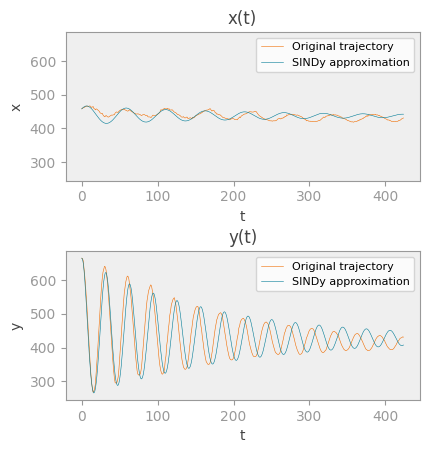

In [11]:
u0x = np.array([u[0, 0], xdot[0, 0]])
u_approximation_x = modelx.simulate(u0x, t)

u0y = np.array([u[0, 1], ydot[0, 0]])
u_approximation_y = modely.simulate(u0y, t)

graph_result(u, u_approximation_x, u_approximation_y, t)